## Sequence context modeling of substitution probabilities

### data deal
the KG SNP dataset was downloaded from KG data, selected high coverage data(deep >30X) that 2504 samples in totial. the different population dataset was obtianed using custom script.

 20160622.allChr.mask.bed was downloaded from http://ftp.1000genomes.ebi.ac.uk/vol1/ftp/data_collections/1000_genomes_project/working/20160622_genome_mask_GRCh38/StrictMask/20160622.allChr.mask.bed
hg38.chrom.sizes was download from https://hgdownload.cse.ucsc.edu/goldenpath/hg38/bigZips/hg38.chrom.sizes

##### hg38.genomes_bed was obtained using  ```awk -v OFS="\t"  '{print $1,1,$2 }'  hg38.chrom.sizes|sort -k1,1 -k2,2n |grep -v "chrM" > hg38.genomes_bed ```

##### hg38.genomes.endregion was obtained using ```awk -v OFS="\t"  '{print $1,0,20000"\n"$1, $2-20000,$2 }' hg38.chrom.sizes |grep -v "chrM" |sort -k1,1 -k2,2n > hg38.genomes.endregion```

In [ ]:
# gene annotion obtian 
import pyranges as pr
import os
wdpath = "/disk2/G4_MS/frequency/Severmer/data"
reference_path = "/disk2/G4_MS/reference"

df = pr.read_gtf(os.path.join(reference_path,"gencode.v38.annotation.gtf"))
df = df[df.Feature == "gene"]
df = df.as_df()
df.loc[:,["Chromosome", "Start", "End","gene_id","gene_name","Strand"]].to_csv(
    os.path.join(wdpath,"gene_region_annotion.merge.tsv"),sep="\t",index=False)

In [ ]:
# -*- coding: utf-8 -*-
# @Time : 2021/5/20 10:28
# @Author : guangyuel
# @File : sevenMer.py

import os
import re
import pandas as pd
import pyranges as pr
import sys
from collections.abc import Iterable
from itertools import product
from collections import Counter



def seven_mer_get(seq):
    seq = seq.upper()
    sep = 7
    c = 0
    while c <= len(seq)-sep:
        yield seq[c: c+sep]
        c += 1

def flattern(items,ignore_types=(str,bytes)):
    for x in items:
        if isinstance(x,Iterable) and not isinstance(x,ignore_types):
            yield from flattern(x)
        else:
            yield x

def seq_reverse(seven_mer):
    transDict = {"A": "T",
                 "C": "G",
                 "G": "C",
                 "T": "A"
                 }
    seven_mer = [transDict[item] for item in list(seven_mer)[::-1]]
    return "".join(seven_mer)

def arrays_get():
    a,b,c,d,e,f,g = [["A","T","C","G"]]*7
    for seq in product(a,b,c,d,e,f,g):
        ref = "".join(seq)
        altBases = ["A","T","C","G"]
        altBases.remove(seq[3])
        for alt in altBases:
            talt = list(seq)
            talt[3] = alt
            alts = ''.join(talt)
            yield ref + "|"+alts

def reverse_merge(ndict):
    newdict = {}
    for k in arrays_get():
        if ndict.get(k):
            kcont_alt, kcount_ref = ndict.pop(k)
            ref,alt = k.split("|")
            reversek = seq_reverse(ref) + "|" + seq_reverse(alt)
            if ndict.get(reversek):
                reverse_count_alt, reverse_count_ref = ndict.pop(reversek)
            else:
                reverse_count_alt, reverse_count_ref = 0, 0
            newdict[k] = 1.0 * (kcont_alt+ reverse_count_alt) / (kcount_ref + reverse_count_ref)
    return newdict


def probability_compute(refcount,snpdict):
    def alt_get(ref, alt):
        tp_alt = list(str(ref))
        tp_alt[3] = alt
        return "".join(tp_alt)

    result = {}
    for key in refcount.keys():
        if "N" in key:
            continue
        bases = ["T","C","G","A"]
        ref_base = key[3]
        bases.remove(ref_base)
        for alt_base in bases:
            alt = alt_get(key,alt_base)
            snp_key = key+"|"+alt
            if not snpdict.get(snp_key):
                snp_count = 0
            else:
                snp_count = snpdict[snp_key]
            if refcount.get(key):
                ref_count = refcount[key]
            else:
                print(key)
                ref_count = 0
            pro = [snp_count, ref_count]
            result[snp_key] = pro
    return reverse_merge(result)

def probroblity_get(probiblity,fileopject):
    for k in probiblity.keys():
        ref,alt = k.split("|")
        fileopject.write("\t".join(k.split("|")) + "\t" + str(probiblity[k]) + "\t" + seq_reverse(ref) + "\t"+seq_reverse(alt) + "\n"
                         )

def fre_prepare(dff):
    def alt_get(ref, alt):
        tp_alt = list(str(ref))
        tp_alt[3] = alt
        return "".join(tp_alt)
    dff["seq"] = dff["seq"].map(lambda x: x.upper())
    dff["altseq"] = dff.apply(lambda x: alt_get(x["seq"], x["Alt"]), axis=1)
    dff["mergeseq"] = dff["seq"].map(str) + "|" + dff["altseq"].map(str)
    return Counter(list(dff["mergeseq"]))

def kg_filter(df_path, refnumbers, frequency=0.005):
    df = pr.PyRanges(pd.read_table(df_path, header=None,
                                   names=["Chromosome", "Start", "End", "Ref", "Alt", "Info", "Type", "Altmumbers",
                                          "Refnumbers", "seq"]))
    df = df[df.Refnumbers > int(refnumbers) * 0.8]
    df = df[df.Altmumbers / df.Refnumbers > frequency]
    return df.as_df()

if __name__ == "__main__":
    ref_all = []
    with open(sys.argv[1])as fr:
        for line in fr:
            uline = line.strip().split("\t")
            seq = uline[3]
            ref_all.append(seven_mer_get(seq))
    ref_all = flattern(ref_all)
    
    df_eur = kg_filter(sys.argv[2], 1006)
    df_eas = kg_filter(sys.argv[3], 1008)
    df_amr = kg_filter(sys.argv[4], 694)
    df_sas = kg_filter(sys.argv[5], 978)
    df_afr = kg_filter(sys.argv[6], 1322)

    eurd = fre_prepare(df_eur)
    easd = fre_prepare(df_eas)
    amrd = fre_prepare(df_amr)
    sasd = fre_prepare(df_sas)
    afrd = fre_prepare(df_afr)

    del df_eur, df_eas, df_amr, df_sas, df_afr

    ## deal ref
    ref_count = Counter(list(ref_all))

    eurmerge = probability_compute(ref_count, eurd)
    easmerge = probability_compute(ref_count, easd)
    amrmerge = probability_compute(ref_count, amrd)
    sasmerge = probability_compute(ref_count, sasd)
    afrmerge = probability_compute(ref_count, afrd)
    del eurd, easd, amrd, sasd, afrd
    result = {"eur":eurmerge, "eas": easmerge, "amr": amrmerge,"sas": sasmerge, "afr": afrmerge}

    for popu in result.keys():
        with open("kg_substitution_probabilities."+popu.upper()+".tsv", 'w') as fw:
            probroblity_get(result[popu], fw)

In [ ]:
## @ 7mer_refseq.py
from Bio import SeqIO
import pyranges as pr
import pandas as pd
import os, sys

def fasta_get(gnomic_fa_dict, chrome, start, end):
    return gnomic_fa_dict[chrome][int(start) - 1:int(end) - 1]
def subtitution_fre_get(df,sub_fre,gnomic_fa, fileName):

    df = df.window(1).as_df()
    df = df.iloc[:,[0,1,2]]
    df.loc[:,"Seq"] = df.apply(lambda row: str(fasta_get(gnomic_fa, row["Chromosome"], row["Start"] - 3, row["End"] + 3).seq).upper(),
                               axis=1)
    df = df.merge(sub_fre,left_on="Seq",right_index=True)
    df.to_csv(fileName,index=None, sep="\t")

hg38_path = "/usr/refence/hg38/hg38.fa"
gnomic_fa = SeqIO.to_dict(SeqIO.parse(hg38_path, format="fasta"))

gene_path = sys.argv[1]
sub_fre_path = sys.argv[2]
sub_fre_paths = [os.path.join(sub_fre_path,p)
    for p in ["kg_substitution_probabilities.EUR.tsv","kg_substitution_probabilities.EAS.tsv",
          "kg_substitution_probabilities.AMR.tsv","kg_substitution_probabilities.SAS.tsv",
          "kg_substitution_probabilities.AFR.tsv"]
]
fileName = sys.argv[3]
sub_fres = []
for p in sub_fre_paths:
    pre_sub_fre = pd.read_table(p, header=None)
    sub_fres.append(
        pd.concat([pre_sub_fre.groupby(0).agg(sum),pre_sub_fre.groupby(3).agg(sum)])
    )
sub_fre = pd.concat(sub_fres,axis=1)
sub_fre.columns = ["EUR","EAS","AMR","SAS","AFS"]

gene_df = pr.PyRanges(pd.read_table(gene_path))
gene_df = gene_df.merge()
subtitution_fre_get(gene_df,sub_fre,gnomic_fa,fileName=fileName)


In [ ]:
%%bash
cd /disk2/G4_MS/frequency/Severmer/data
tail -n +2 gene_region_annotion.merge.tsv|bedtools sort -i - |bedtools slop -i - -g /disk2/G4_MS/reference/hg38.chromsome.sizes -b 2000|bedtools merge -i - > gene_region_annotion.merge.bed
bedtools subtract -a hg38.genomes_bed -b gene_region_annotion.merge.bed |bedtools intersect -wa -a - -b 20160622.allChr.mask.bed|bedtools merge -i - |bedtools subtract -a - -b hg38.genomes.endregion > last_intergenetic.region.bed
grep -v "chrX" last_intergenetic.region.bed|grep -v "chrY" > last_intergenetic.region.noXY.bed
awk -v OFS="\t" '{$2=$2-4;$3=$3+2;print $0}' last_intergenetic.region.noXY.bed|awk -v OFS="\t" '{if($2<0){$2=1};print $0}' |bedtools merge -i - |bedtools getfasta -fi /usr/refence/hg38/hg38.fa -bed - -tab|sed 's/:/\t/g'|sed s'/-/\t/g' > last_intergenetic.region.noXY.fasta.up_down.bed

bedtools intersect -wa -a /disk2/G4_MS/reference/1000G_PASS_SNP_EUR.tsv -b last_intergenetic.region.noXY.bed > 1000G_PASS_SNP_EUR_overlap_intergentic.snp.bed
bedtools intersect -wa -a /disk2/G4_MS/reference/1000G_PASS_SNP_EAS.tsv -b last_intergenetic.region.noXY.bed > 1000G_PASS_SNP_EAS_overlap_intergentic.snp.bed
bedtools intersect -wa -a /disk2/G4_MS/reference/1000G_PASS_SNP_SAS.tsv -b last_intergenetic.region.noXY.bed > 1000G_PASS_SNP_SAS_overlap_intergentic.snp.bed
bedtools intersect -wa -a /disk2/G4_MS/reference/1000G_PASS_SNP_AFR.tsv -b last_intergenetic.region.noXY.bed > 1000G_PASS_SNP_AFR_overlap_intergentic.snp.bed
bedtools intersect -wa -a /disk2/G4_MS/reference/1000G_PASS_SNP_AMR.tsv -b last_intergenetic.region.noXY.bed > 1000G_PASS_SNP_AMR_overlap_intergentic.snp.bed

awk -v OFS="\t" '{$2=$2-4;$3=$3+2;print $0}' 1000G_PASS_SNP_AMR_overlap_intergentic.snp.bed |bedtools getfasta -fi /usr/refence/hg38/hg38.fa -bed - -tab|cut -f2 > 1000G_PASS_SNP_AMR_overlap_intergentic.snp.fasta
awk -v OFS="\t" '{$2=$2-4;$3=$3+2;print $0}' 1000G_PASS_SNP_AFR_overlap_intergentic.snp.bed |bedtools getfasta -fi /usr/refence/hg38/hg38.fa -bed - -tab|cut -f2 > 1000G_PASS_SNP_AFR_overlap_intergentic.snp.fasta
awk -v OFS="\t" '{$2=$2-4;$3=$3+2;print $0}' 1000G_PASS_SNP_EUR_overlap_intergentic.snp.bed |bedtools getfasta -fi /usr/refence/hg38/hg38.fa -bed - -tab|cut -f2 > 1000G_PASS_SNP_EUR_overlap_intergentic.snp.fasta
awk -v OFS="\t" '{$2=$2-4;$3=$3+2;print $0}' 1000G_PASS_SNP_EAS_overlap_intergentic.snp.bed |bedtools getfasta -fi /usr/refence/hg38/hg38.fa -bed - -tab|cut -f2 > 1000G_PASS_SNP_EAS_overlap_intergentic.snp.fasta
awk -v OFS="\t" '{$2=$2-4;$3=$3+2;print $0}' 1000G_PASS_SNP_SAS_overlap_intergentic.snp.bed |bedtools getfasta -fi /usr/refence/hg38/hg38.fa -bed - -tab|cut -f2 > 1000G_PASS_SNP_SAS_overlap_intergentic.snp.fasta


paste 1000G_PASS_SNP_EUR_overlap_intergentic.snp.bed 1000G_PASS_SNP_EUR_overlap_intergentic.snp.fasta > 1000G_PASS_SNP_EUR_overlap_intergentic.snp.fasta.bed
paste 1000G_PASS_SNP_EAS_overlap_intergentic.snp.bed 1000G_PASS_SNP_EAS_overlap_intergentic.snp.fasta > 1000G_PASS_SNP_EAS_overlap_intergentic.snp.fasta.bed
paste 1000G_PASS_SNP_SAS_overlap_intergentic.snp.bed 1000G_PASS_SNP_SAS_overlap_intergentic.snp.fasta > 1000G_PASS_SNP_SAS_overlap_intergentic.snp.fasta.bed
paste 1000G_PASS_SNP_AFR_overlap_intergentic.snp.bed 1000G_PASS_SNP_AFR_overlap_intergentic.snp.fasta > 1000G_PASS_SNP_AFR_overlap_intergentic.snp.fasta.bed
paste 1000G_PASS_SNP_AMR_overlap_intergentic.snp.bed 1000G_PASS_SNP_AMR_overlap_intergentic.snp.fasta > 1000G_PASS_SNP_AMR_overlap_intergentic.snp.fasta.bed

python sevenMer.py last_intergenetic.region.noXY.fasta.up_down.bed 1000G_PASS_SNP_EUR_overlap_intergentic.snp.fasta.bed1000G_PASS_SNP_EAS_overlap_intergentic.snp.fasta.bed 1000G_PASS_SNP_AMR_overlap_intergentic.snp.fasta.bed 1000G_PASS_SNP_SAS_overlap_intergentic.snp.fasta.bed 1000G_PASS_SNP_AFR_overlap_intergentic.snp.fasta.bed
python 7mer_refseq.py promoter_region.tsv /disk2/G4_MS/frequency/Severmer/data promoter_region.substitution.tsv

## substitution probabilities analysis

#### all-pG4 analysis

In [ ]:
## 7mer.analysis.py
# -*- coding: utf-8 -*-
# @Time    : 2022/9/27 9:56
# @Author  : Guangyuel

import os
import pandas as pd
from itertools import groupby, product
import re
from Bio import SeqIO
from collections.abc import Iterable
import numpy as np
import logging
import pyranges as pr


def log():
    logger = logging.getLogger("substitus")
    # set log level
    logger.setLevel(logging.DEBUG)
    if not logger.handlers:
        ch = logging.StreamHandler()
        # log format set
        formatter = logging.Formatter(
            fmt="%(asctime)s %(name)s %(levelname)s %(message)s",
            datefmt="%y-%m-%d %X"
        )
        ch.setFormatter(formatter)
        logger.addHandler(ch)

    return logger


def seven_mer_get(seq):
    seq = seq.upper()
    sep = 7
    c = 0
    while c <= len(seq) - sep:
        yield seq[c: c + sep]
        c += 1


def flattern(items, ignore_types=(str, bytes)):
    for x in items:
        if isinstance(x, Iterable) and not isinstance(x, ignore_types):
            yield from flattern(x)
        else:
            yield x


def seq_reverse(seven_mer):
    transDict = {"A": "T",
                 "C": "G",
                 "G": "C",
                 "T": "A"
                 }
    seven_mer = [transDict[item] for item in list(seven_mer)[::-1]]
    return "".join(seven_mer)


def arrays_get():
    a, b, c, d, e, f, g = [["A", "T", "C", "G"]] * 7
    for seq in product(a, b, c, d, e, f, g):
        ref = "".join(seq)
        yield ref


def reverse_merge(arrays_get, ndict):
    newdict = {}
    for k in arrays_get:
        if ndict.get(k):
            kcount = ndict.pop(k)
            reversek = seq_reverse(k)
            if ndict.get(reversek):
                reverse_count = ndict.pop(reversek)
            else:
                reverse_count = 0
            newdict[k] = kcount + reverse_count
    return newdict


def Gtrack_get(seq, plus=True):
    result = []
    ggg = []
    seqindex = []
    for index, val in enumerate(list(seq)):
        if plus:
            if val == 'g' or val == 'G':
                ggg.append(index)
        else:
            if val == 'c' or val == 'C':
                ggg.append(index)
    for k, g in groupby(enumerate(ggg), lambda x: x[1] - x[0]):
        _ = [j for i, j in g]
        if len(_) >= 3:
            seqindex.append(_)
    if len(seqindex) > 0:
        for idx in seqindex:
            result.append((idx[0], idx[-1] + 1))
    return result

def G4_info(df):
    result = []
    df = df.drop_duplicates(keep="first", subset=["Chromosome", "Start", "End"])
    df = pr.PyRanges(df).max_disjoint(slack=100,strand=False).as_df()
    df = df[df["Chromosome"] != "chrX"]
    df = df[df["Chromosome"] != "chrY"]
    df = df[df["G4_length"] <= 100]
    g4_numbers = 0
    g4_lengths = 0
    grunsNumbers = 0
    gloopNumbers = 0
    for index, row in df.iterrows():
        g4_numbers += 1
        g4_lengths += row.G4_length
        plusflg = True
        if row["Strand"] == "-": plusflg = False
        tp_track = Gtrack_get(row["Name"], plus=plusflg)
        stem = []
        loop = []
        for i in range(len(tp_track)-1):
            if plusflg:
                stem_tmp = [row["Chromosome"], row["Start"]+tp_track[i][0], row["Start"]+tp_track[i][1], "+", "stem"]
                stem.append(stem_tmp)
                loop_tmp = [row["Chromosome"], row["Start"]+tp_track[i][1], row["Start"]+tp_track[i+1][0], "+", "loop"]
                loop.append(loop_tmp)
            else:
                stem_tmp = [row["Chromosome"], row["Start"]+tp_track[i][0], row["Start"]+tp_track[i][1], "-", "stem"]
                stem.append(stem_tmp)
                loop_tmp = [row["Chromosome"], row["Start"]+tp_track[i][1], row["Start"]+tp_track[i+1][0], "-", "loop"]
                loop.append(loop_tmp)
        if plusflg:
            stem_tmp = [row["Chromosome"], row["Start"] + tp_track[-1][0], row["Start"] + tp_track[-1][1], "+", "stem"]
            flank1 = [row["Chromosome"], row["Start"] + tp_track[0][0] - 100, row["Start"] + tp_track[0][0], "+",
                      "flank1"]
            flank2 = [row["Chromosome"], row["Start"] + tp_track[-1][1], row["Start"] + tp_track[-1][1] + 100, "+",
                      "flank2"]
        else:
            stem_tmp = [row["Chromosome"], row["Start"] + tp_track[-1][0], row["Start"] + tp_track[-1][1], "-", "stem"]
            flank2 = [row["Chromosome"]] + [row["Start"] + tp_track[0][0] - 100, row["Start"] + tp_track[0][0], "-",
                                            "flank2"]
            flank1 = [row["Chromosome"]] + [row["Start"] + tp_track[-1][1], row["Start"] + tp_track[-1][1] + 100, "-",
                                            "flank1"]
        stem.append(stem_tmp)
        result += stem
        result += loop
        grunsNumbers += len(tp_track)
        gloopNumbers += len(tp_track) - 1
        result += [flank1, flank2]
    return result, g4_numbers, g4_lengths / g4_numbers, grunsNumbers, gloopNumbers


def fasta_get(gnomic_fa_dict, chrome, start, end):
    return gnomic_fa_dict[chrome][int(start) - 1:int(end) - 1]


def cpg_patterns():
    a, b, c = [["A", "T", "C", "G"]] * 3
    two_mer = ["".join(i) for i in product(a, b)]
    three_mer = ["".join(i) for i in product(a, b, c)]
    cg = ["CG"]
    gc = ["GC"]
    all_cpgs = set(
        [''.join(i) for i in product(two_mer, cg, three_mer)] + [''.join(i) for i in product(two_mer, gc, three_mer)] +
        [''.join(i) for i in product(three_mer, cg, two_mer)] + [''.join(i) for i in product(three_mer, gc, two_mer)])
    return all_cpgs


def pos_list(chrome, start, end):
    for p in range(int(start), int(end)):
        tp_start, tp_end = p, p + 1
        yield (chrome, tp_start, tp_end)


def nog4_boost(noG4info, population, substitution, regions=27, regionnumber=17958):
    def array_get(start, sep=regions):
        return np.arange(start, start + sep)

    count = 0
    rs = []
    while count < 10000:
        randas = []
        randams = np.random.choice(np.arange(noG4info.index.argmax() - regions), size=regionnumber)
        for i in randams:
            randas.append(array_get(i))
        select_index = set(np.concatenate(randas))
        tp = noG4info[noG4info.index.isin(select_index)]
        tp_population = population[population["key"].isin(tp["key"])]
        exp = 0
        for _ in tp["Seq"]:
            if substitution.get(_):
                exp += substitution[_]
        obs = len(tp_population.index)
        rs.append(obs/exp)
        count += 1
    return rs


def noG4_threading_get(noG4info, population, substitution, regions=27, g4number=17958):
    population = population.reset_index(drop=True)
    noG4info = noG4info.reset_index(drop=True)
    noG4info.loc[:, "key"] = noG4info["Chromosome"] + "|" + noG4info["Start"].map(str) + "|" + noG4info["End"].map(str)
    population.loc[:, "key"] = population["Chromosome"].astype(str) + "|" + population["Start"].map(str) + "|" + \
                               population["End"].map(str)
    rs = []
    rs += nog4_boost(noG4info, population, substitution, regions=regions, regionnumber=g4number)
    return rs


def g4_pos_df_get(df, cpgs):
    pG4_all_seq = {}
    for index, row in df.iterrows():
        pos = pos_list(row["Chromosome"], row["Start"], row["End"])
        ref_seq = str(fasta_get(gnomic_fa, row["Chromosome"], row["Start"] - 3, row["End"] + 3).seq).upper()
        for i in zip(pos, seven_mer_get(ref_seq)):
            pG4_all_seq[i[0]] = i[1]
    pre_all_df = []
    for k, v in pG4_all_seq.items():
        pre_all_df.append([k[0], k[1], k[2], v])

    all_df = pd.DataFrame(pre_all_df, columns=["Chromosome", "Start", "End", "Seq"])
    all_df = all_df[~all_df["Seq"].isin(cpgs)]
    all_df = all_df[~all_df["Chromosome"].isin(["chrX", "chrY"])]
    all_df = all_df.drop_duplicates(subset=["Chromosome", "Start", "End"])
    return all_df

def g4_boostloop(g4_all, g4_population, exps):
    g4_population = g4_population.reset_index(drop=True)
    g4_all = g4_all.reset_index(drop=True)
    g4_all.loc[:, "key"] = g4_all["Chromosome"].astype(str) + "|" + g4_all["Start"].map(str) + "|" + g4_all["End"].map(
        str)
    g4_population.loc[:, "key"] = g4_population["Chromosome"].astype(str) + "|" + g4_population["Start"].map(
        str) + "|" + g4_population["End"].map(str)

    count = 0
    rs = []
    while count < 10000:
        tp_all_df = g4_all.sample(g4_all.index.argmax(), replace=True)
        #         tp_all_df = tp_all_df.drop_duplicates()
        tp_snp_df = tp_all_df[tp_all_df["key"].isin(g4_population["key"])]
        obs = tp_snp_df.shape[0]
        exp = 0
        for _ in tp_all_df["Seq"]:
            if exps.get(_):
                exp += exps[_]
        rs.append(obs/exp)
        count += 1
    return rs


def devion_compute(all_df, snp_df, exps):
    all_df.loc[:, "key"] = all_df["Chromosome"].astype(str) + "|" + all_df["Start"].map(str) + "|" + all_df["End"].map(
        str)
    snp_df.loc[:, "key"] = snp_df["Chromosome"].astype(str) + "|" + snp_df["Start"].map(str) + "|" + snp_df["End"].map(
        str)
    snp_df = snp_df[snp_df["key"].isin(all_df["key"])]
    obs = snp_df.shape[0]
    exp = 0
    for _ in all_df["Seq"]:
        if exps.get(_):
            exp += exps[_]
    return str(obs)+"|" + str(exp)


def kg_filter(df_path, refnumbers, frequency=0.005):
    df = pr.PyRanges(pd.read_table(df_path, header=None,
                                   names=["Chromosome", "Start", "End", "Ref", "Alt", "Info", "Type", "Altmumbers",
                                          "Refnumbers"]))
    df = df[df.Refnumbers > int(refnumbers) * 0.8]
    df = df[df.Altmumbers / df.Refnumbers > frequency]
    df = df.drop_duplicate_positions()
    return df

def nonG4_threading(sub_ref, kg_snp, nonG4_genes, cds, g4_mean_length,g4Number, boostNumber=10000):
    result = {"EUR":[],"EAS":[],"SAS":[], "AMR":[], "AFR":[]}
    n = 0
    nonG4_genes = nonG4_genes.merge()
    nonG4_genes = nonG4_genes.subtract(cds)
    used_sub_ref = sub_ref.overlap(nonG4_genes)
    mean_result = {}
    for k in kg_snp.keys():
        obs = kg_snp[k].overlap(nonG4_genes).__len__()
        mean_result[k]=obs/used_sub_ref.as_df()[k].sum()
    while n < boostNumber:
        tp_nonG4_select = nonG4_genes.window(int(g4_mean_length))
        tp_nonG4_select = tp_nonG4_select.sample(g4Number)
        tp_nonG4 = used_sub_ref.overlap(tp_nonG4_select).as_df()
        for k in kg_snp.keys():
            obs = kg_snp[k].overlap(tp_nonG4_select).as_df().shape[0]
            result[k].append(obs/tp_nonG4[k].sum())
        n += 1
    return mean_result,pd.DataFrame(result)
        
def pG4_df_dropdupicates(gr, cpgs, gnomic_fa):
#     gr = gr.drop_duplicate_positions()
    gr = gr.as_df()
    gr["Seq"] = gr.apply(
        lambda x: str(fasta_get(gnomic_fa, x["Chromosome"], int(x["Start"]) - 3, int(x["End"]) + 3).seq.upper()),
        axis=1)
    gr = gr[~gr["Seq"].isin(cpgs)]
    gr = pr.PyRanges(gr)
    return gr


def G4_threading(sub_ref, kg_snp, G4_genes, cds,  boostNumber=10000):
    result = {"EUR":[],"EAS":[],"SAS":[], "AMR":[], "AFR":[]}
    n = 0
    G4_genes = pr.PyRanges(G4_genes).subtract(cds)
    used_sub_ref = sub_ref.overlap(G4_genes)
    
    mean_result = {}
    for k in kg_snp.keys():
        obs = kg_snp[k].overlap(G4_genes).__len__()
        mean_result[k]=obs/used_sub_ref.as_df()[k].sum()
        
    G4_genes = G4_genes.as_df()
    while n < boostNumber:
        tp_G4_select = pr.PyRanges(G4_genes.sample(G4_genes.shape[0],replace=True))
        tp_G4 = used_sub_ref.overlap(tp_G4_select).as_df()
        for k in kg_snp.keys():
            obs = kg_snp[k].overlap(tp_G4_select).__len__()
            result[k].append(obs/tp_G4[k].sum())
        n += 1
    return mean_result, pd.DataFrame(result)

if __name__ == "__main__":
    logger = log()
    logger.info("Start")
    arrays = list(arrays_get())
    ##
    data_path = "/disk2/G4_MS/frequency/Severmer/data"
    promoter_path = "/disk2/G4_MS/promoter_select/promoter_info"
    tss_pG4_path = os.path.join(promoter_path,"promoter_pG4.info.tsv")
    epG4_path = os.path.join(promoter_path,"promoter_pG4.info.H3K4me3.tsv")
    hg38_path = "/usr/refence/hg38/hg38.fa"
    reference_path = "/disk2/G4_MS/reference"
    ## kg ##
    kg_eur = os.path.join("/disk2/G4_MS/reference", "1000G_PASS_SNP_EUR.tsv")
    kg_eas = os.path.join("/disk2/G4_MS/reference", "1000G_PASS_SNP_EAS.tsv")
    kg_sas = os.path.join("/disk2/G4_MS/reference", "1000G_PASS_SNP_SAS.tsv")
    kg_afr = os.path.join("/disk2/G4_MS/reference", "1000G_PASS_SNP_AFR.tsv")
    kg_amr = os.path.join("/disk2/G4_MS/reference", "1000G_PASS_SNP_AMR.tsv")
    kg_eur = kg_filter(kg_eur, 1006)
    kg_eas = kg_filter(kg_eas, 1008)
    kg_sas = kg_filter(kg_sas, 978)
    kg_afr = kg_filter(kg_afr, 1322)
    kg_amr = kg_filter(kg_amr, 694)
    kg_snp = {
        "EUR":kg_eur,
        "EAS":kg_eas,
        "SAS":kg_sas,
        "AMR":kg_amr,
        "AFR":kg_afr
    }
    
    ## reference data obtain
    gnomic_fa = SeqIO.to_dict(SeqIO.parse(hg38_path, format="fasta"))
    cpgs = cpg_patterns()
    cds = pr.read_bed(os.path.join(reference_path,"gencode38.cds_region.bed"))
    
    for k in kg_snp.keys():
        kg_snp[k] = pG4_df_dropdupicates(kg_snp[k],cpgs, gnomic_fa)
        
    sub_ref = pr.PyRanges(pd.read_table(os.path.join(data_path,"promoter_region.substitution.tsv")))
    sub_ref = sub_ref[~sub_ref.Seq.isin(cpgs)]
    ## tss    
    tss = pd.read_table(os.path.join(promoter_path, "promoter.annotion.tsv"))
    tss_pG4 = pd.read_table(tss_pG4_path)
    tss_pG4 = tss_pG4.drop_duplicates(subset=["Chromosome","Start","End","Name","G4_length","Strand","Score"])
    tss_pG4_info, g4numbers, g4_mean_length, g4stemNumber, g4loopNumber = G4_info(tss_pG4)
    tss_pG4_info = pd.DataFrame(tss_pG4_info, columns=["Chromosome", "Start", "End", "Strand", "type"])
    
    nonG4_genes = pd.read_table(os.path.join(promoter_path,"promoter_nopG4.info.tsv"))
    nonG4_genes = pr.PyRanges(nonG4_genes)
    nonG4_genes = nonG4_genes[(nonG4_genes.Chromosome != "chrX") & (nonG4_genes.Chromosome != "chrY") &(nonG4_genes.Chromosome != "chrM")]
       
    logger.info(f"""tss pG4 G4Number: {g4numbers}\ntss pG4 G-tracts: {g4stemNumber}\ntss pG4 loops: {g4loopNumber}""")
    nonpG4_result,nonpG4_boost_result = nonG4_threading(sub_ref,kg_snp,nonG4_genes,cds,g4_mean_length,g4numbers,boostNumber=10)
    
    nonpG4_boost_result.to_csv("tss_nonpG4_boost.result.tsv",sep="\t",index=False)
    
    pG4_groups = {
    "flank1":tss_pG4_info[tss_pG4_info["type"].isin(["flank1"])],
    "stem":tss_pG4_info[tss_pG4_info["type"].isin(["stem"])],
    "loop":tss_pG4_info[tss_pG4_info["type"].isin(["loop"])],
    "flank2":tss_pG4_info[tss_pG4_info["type"].isin(["flank2"])],  
    }
    pG4_result_bost = {}
    pG4_result = {}
    for k in pG4_groups.keys():
        pG4_result[k], pG4_result_bost[k]= G4_threading(sub_ref, kg_snp, pG4_groups[k], cds,  boostNumber=10)
    for k in pG4_result_bost.keys():
        pG4_result_bost[k].to_csv("tss_pG4."+k+'.result.tsv',sep="\t",index=False)
    del nonG4_genes
    #### eG4 analysis
    epromoter = pd.read_table(os.path.join(promoter_path, "promoter_info.annotion.H3K4me3.tsv"))
    eG4 = pd.read_table(epG4_path)
    eG4 = eG4.drop_duplicates(subset=["Chromosome","Start","End","Name","G4_length","Strand","Score"])
    epG4_info, g4numbers, g4_mean_length, g4stemNumber, g4loopNumber = G4_info(eG4)
    epG4_info = pd.DataFrame(epG4_info, columns=["Chromosome", "Start", "End", "Strand", "type"])
    logger.info(f"""epG4 G4Number: {g4numbers}\ntss epG4 G-tracts: {g4stemNumber}\ntss epG4 loops: {g4loopNumber}""")
    
    nonG4_genes = pd.read_table(os.path.join(promoter_path,"promoter_nopG4.info.H3K4me3.tsv"))
    nonG4_genes = pr.PyRanges(nonG4_genes)
    nonG4_genes = nonG4_genes[(nonG4_genes.Chromosome != "chrX") & (nonG4_genes.Chromosome != "chrY") &(nonG4_genes.Chromosome != "chrM")]
    enonpG4_result,enonpG4_boost_result = nonG4_threading(sub_ref,kg_snp,nonG4_genes,cds,g4_mean_length,g4numbers,boostNumber=10)
    enonpG4_boost_result.to_csv("activePromoter_nonpG4_boost.result.tsv",sep="\t",index=False)
    
    eG4_groups = {
    "flank1":epG4_info[epG4_info["type"].isin(["flank1"])],
    "stem":epG4_info[epG4_info["type"].isin(["stem"])],
    "loop":epG4_info[epG4_info["type"].isin(["loop"])],
    "flank2":epG4_info[epG4_info["type"].isin(["flank2"])],  
    }
    
    eG4_result_bost = {}
    eG4_result = {}
    for k in eG4_groups.keys():
        eG4_result[k], eG4_result_bost[k]= G4_threading(sub_ref, kg_snp, eG4_groups[k], cds,  boostNumber=10)
    for k in eG4_result_bost.keys():
        eG4_result_bost[k].to_csv("activePromoter_pG4."+k+'.result.tsv',sep="\t",index=False)

    df_list = []
    for k in ["EUR","EAS","SAS","AMR","AFR"]:
        for g in pG4_result.keys():
            tplist = []
            tplist += [pG4_result[g][k], g, k,"Promoter"]
            df_list.append(tplist)
            
        tplist = []
        tplist += [nonpG4_result[k],"nonG4", k, "Promoter"]
        df_list.append(tplist)
        for g in eG4_result.keys():
            tplist = []
            tplist += [eG4_result[g][k], g, k,"Active promoter"]
            df_list.append(tplist)
        tplist = []
        tplist += [enonpG4_result[k],"nonG4", k, "Active promoter"]
        df_list.append(tplist)
    df = pd.DataFrame(df_list,columns=["ratio","g4_type","population","groups"])
    df.to_csv("sevenMer.ratio.mean.tsv",sep="\t", index=False)

### stable-pG4 analysis

In [ ]:
###  cat 7mer.Stable.py
# -*- coding: utf-8 -*-
# @Time    : 2022/10/30 13:40
# @Author  : Guangyuel

import os
import pandas as pd
from itertools import groupby, product
from Bio import SeqIO
import numpy as np
import logging
import pyranges as pr


def log():
    logger = logging.getLogger("substitus")
    # set log level
    logger.setLevel(logging.DEBUG)
    if not logger.handlers:
        ch = logging.StreamHandler()
        # log format set
        formatter = logging.Formatter(
            fmt="%(asctime)s %(name)s %(levelname)s %(message)s",
            datefmt="%y-%m-%d %X"
        )
        ch.setFormatter(formatter)
        logger.addHandler(ch)

    return logger


def arrays_get():
    a, b, c, d, e, f, g = [["A", "T", "C", "G"]] * 7
    for seq in product(a, b, c, d, e, f, g):
        ref = "".join(seq)
        yield ref


def Gtrack_get(seq, plus=True):
    result = []
    ggg = []
    seqindex = []
    for index, val in enumerate(list(seq)):
        if plus:
            if val == 'g' or val == 'G':
                ggg.append(index)
        else:
            if val == 'c' or val == 'C':
                ggg.append(index)
    for k, g in groupby(enumerate(ggg), lambda x: x[1] - x[0]):
        _ = [j for i, j in g]
        if len(_) >= 3:
            seqindex.append(_)
    if len(seqindex) > 0:
        for idx in seqindex:
            result.append((idx[0], idx[-1] + 1))
    return result


def G4_info(df):
    result = []
    df = df.drop_duplicates(keep="first", subset=["Chromosome", "Start", "End"])
    df = pr.PyRanges(df).max_disjoint(slack=100, strand=False).as_df()
    df = df[df["Chromosome"] != "chrX"]
    df = df[df["Chromosome"] != "chrY"]
    df = df[df["G4_length"] <= 100]
    g4_numbers = 0
    g4_lengths = 0
    grunsNumbers = 0
    gloopNumbers = 0
    for index, row in df.iterrows():
        g4_numbers += 1
        g4_lengths += row.G4_length
        plusflg = True
        if row["Strand"] == "-": plusflg = False
        tp_track = Gtrack_get(row["Name"], plus=plusflg)
        stem = []
        loop = []
        for i in range(len(tp_track) - 1):
            if plusflg:
                stem_tmp = [row["Chromosome"], row["Start"] + tp_track[i][0], row["Start"] + tp_track[i][1], "+",
                            "stem"]
                stem.append(stem_tmp)
                loop_tmp = [row["Chromosome"], row["Start"] + tp_track[i][1], row["Start"] + tp_track[i + 1][0], "+",
                            "loop"]
                loop.append(loop_tmp)
            else:
                stem_tmp = [row["Chromosome"], row["Start"] + tp_track[i][0], row["Start"] + tp_track[i][1], "-",
                            "stem"]
                stem.append(stem_tmp)
                loop_tmp = [row["Chromosome"], row["Start"] + tp_track[i][1], row["Start"] + tp_track[i + 1][0], "-",
                            "loop"]
                loop.append(loop_tmp)
        if plusflg:
            stem_tmp = [row["Chromosome"], row["Start"] + tp_track[-1][0], row["Start"] + tp_track[-1][1], "+", "stem"]
            flank1 = [row["Chromosome"], row["Start"] + tp_track[0][0] - 100, row["Start"] + tp_track[0][0], "+",
                      "flank1"]
            flank2 = [row["Chromosome"], row["Start"] + tp_track[-1][1], row["Start"] + tp_track[-1][1] + 100, "+",
                      "flank2"]
        else:
            stem_tmp = [row["Chromosome"], row["Start"] + tp_track[-1][0], row["Start"] + tp_track[-1][1], "-", "stem"]
            flank2 = [row["Chromosome"]] + [row["Start"] + tp_track[0][0] - 100, row["Start"] + tp_track[0][0], "-",
                                            "flank2"]
            flank1 = [row["Chromosome"]] + [row["Start"] + tp_track[-1][1], row["Start"] + tp_track[-1][1] + 100, "-",
                                            "flank1"]
        stem.append(stem_tmp)
        result += stem
        result += loop
        grunsNumbers += len(tp_track)
        gloopNumbers += len(tp_track) - 1
        result += [flank1, flank2]
    return result, g4_numbers, g4_lengths / g4_numbers, grunsNumbers, gloopNumbers


def fasta_get(gnomic_fa_dict, chrome, start, end):
    return gnomic_fa_dict[chrome][int(start) - 1:int(end) - 1]


def cpg_patterns():
    a, b, c = [["A", "T", "C", "G"]] * 3
    two_mer = ["".join(i) for i in product(a, b)]
    three_mer = ["".join(i) for i in product(a, b, c)]
    cg = ["CG"]
    gc = ["GC"]
    all_cpgs = set(
        [''.join(i) for i in product(two_mer, cg, three_mer)] + [''.join(i) for i in product(two_mer, gc, three_mer)] +
        [''.join(i) for i in product(three_mer, cg, two_mer)] + [''.join(i) for i in product(three_mer, gc, two_mer)])
    return all_cpgs


def pos_list(chrome, start, end):
    for p in range(int(start), int(end)):
        tp_start, tp_end = p, p + 1
        yield (chrome, tp_start, tp_end)


def nog4_boost(noG4info, population, substitution, regions=27, regionnumber=17958):
    def array_get(start, sep=regions):
        return np.arange(start, start + sep)

    count = 0
    rs = []
    while count < 10000:
        randas = []
        randams = np.random.choice(np.arange(noG4info.index.argmax() - regions), size=regionnumber)
        for i in randams:
            randas.append(array_get(i))
        select_index = set(np.concatenate(randas))
        tp = noG4info[noG4info.index.isin(select_index)]
        tp_population = population[population["key"].isin(tp["key"])]
        exp = 0
        for _ in tp["Seq"]:
            if substitution.get(_):
                exp += substitution[_]
        obs = len(tp_population.index)
        rs.append(obs / exp)
        count += 1
    return rs


def kg_filter(df_path, refnumbers, frequency=0.005):
    df = pr.PyRanges(pd.read_table(df_path, header=None,
                                   names=["Chromosome", "Start", "End", "Ref", "Alt", "Info", "Type", "Altmumbers",
                                          "Refnumbers"]))
    df = df[df.Refnumbers > int(refnumbers) * 0.8]
    df = df[df.Altmumbers / df.Refnumbers > frequency]
    df = df.drop_duplicate_positions()
    return df


def nonG4_threading(sub_ref, kg_snp, nonG4_genes, cds, g4_mean_length, g4Number, boostNumber=10000):
    result = {"EUR": [], "EAS": [], "SAS": [], "AMR": [], "AFR": []}
    n = 0
    nonG4_genes = nonG4_genes.merge()
    nonG4_genes = nonG4_genes.subtract(cds)
    used_sub_ref = sub_ref.overlap(nonG4_genes)
    mean_result = {}
    for k in kg_snp.keys():
        obs = kg_snp[k].overlap(nonG4_genes).__len__()
        mean_result[k] = obs / used_sub_ref.as_df()[k].sum()
    while n < boostNumber:
        tp_nonG4_select = nonG4_genes.window(int(g4_mean_length))
        tp_nonG4_select = tp_nonG4_select.sample(g4Number)
        tp_nonG4 = used_sub_ref.overlap(tp_nonG4_select).as_df()
        for k in kg_snp.keys():
            obs = kg_snp[k].overlap(tp_nonG4_select).as_df().shape[0]
            result[k].append(obs / tp_nonG4[k].sum())
        n += 1
    return mean_result, pd.DataFrame(result)


def nonG4_Gtract_threading(sub_ref, kg_snp, nonG4_genes, cds, gtractNumber, boostNumber=10000):
    result = {"EUR": [], "EAS": [], "SAS": [], "AMR": [], "AFR": []}
    n = 0
    nonG4_genes = nonG4_genes.merge()
    nonG4_genes = nonG4_genes.subtract(cds)
    used_sub_ref = sub_ref.overlap(nonG4_genes)
    mean_result = {}
    for k in kg_snp.keys():
        obs = kg_snp[k].overlap(nonG4_genes).__len__()
        mean_result[k] = obs / used_sub_ref.as_df()[k].sum()
    while n < boostNumber:
        tp_nonG4_select = nonG4_genes.sample(gtractNumber)
        tp_nonG4 = used_sub_ref.overlap(tp_nonG4_select).as_df()
        for k in kg_snp.keys():
            obs = kg_snp[k].overlap(tp_nonG4_select).as_df().shape[0]
            result[k].append(obs / tp_nonG4[k].sum())
        n += 1
    return mean_result, pd.DataFrame(result)


def pG4_df_dropdupicates(gr, cpgs, gnomic_fa):
    #     gr = gr.drop_duplicate_positions()
    gr = gr.as_df()
    gr["Seq"] = gr.apply(
        lambda x: str(fasta_get(gnomic_fa, x["Chromosome"], int(x["Start"]) - 3, int(x["End"]) + 3).seq.upper()),
        axis=1)
    gr = gr[~gr["Seq"].isin(cpgs)]
    gr = pr.PyRanges(gr)
    return gr


def G4_threading(sub_ref, kg_snp, G4_genes, cds, boostNumber=10000):
    result = {"EUR": [], "EAS": [], "SAS": [], "AMR": [], "AFR": []}
    n = 0
    G4_genes = pr.PyRanges(G4_genes).subtract(cds)
    used_sub_ref = sub_ref.overlap(G4_genes)

    mean_result = {}
    for k in kg_snp.keys():
        obs = kg_snp[k].overlap(G4_genes).__len__()
        mean_result[k] = obs / used_sub_ref.as_df()[k].sum()

    G4_genes = G4_genes.as_df()
    while n < boostNumber:
        tp_G4_select = pr.PyRanges(G4_genes.sample(G4_genes.shape[0], replace=True))
        tp_G4 = used_sub_ref.overlap(tp_G4_select).as_df()
        for k in kg_snp.keys():
            obs = kg_snp[k].overlap(tp_G4_select).__len__()
            result[k].append(obs / tp_G4[k].sum())
        n += 1
    return mean_result, pd.DataFrame(result)


if __name__ == "__main__":
    logger = log()
    logger.info("Start")
    arrays = list(arrays_get())
    ##
    data_path = "/disk2/G4_MS/frequency/Severmer/data"
    promoter_path = "/disk2/G4_MS/promoter_select/promoter_info"
    tss_pG4_path = os.path.join(promoter_path, "promoter_pG4.info.tsv")
    epG4_path = os.path.join(promoter_path, "promoter_pG4.info.H3K4me3.tsv")
    hg38_path = "/usr/refence/hg38/hg38.fa"
    reference_path = "/disk2/G4_MS/reference"
    ## kg ##
    kg_eur = os.path.join("/disk2/G4_MS/reference", "1000G_PASS_SNP_EUR.tsv")
    kg_eas = os.path.join("/disk2/G4_MS/reference", "1000G_PASS_SNP_EAS.tsv")
    kg_sas = os.path.join("/disk2/G4_MS/reference", "1000G_PASS_SNP_SAS.tsv")
    kg_afr = os.path.join("/disk2/G4_MS/reference", "1000G_PASS_SNP_AFR.tsv")
    kg_amr = os.path.join("/disk2/G4_MS/reference", "1000G_PASS_SNP_AMR.tsv")
    kg_eur = kg_filter(kg_eur, 1006)
    kg_eas = kg_filter(kg_eas, 1008)
    kg_sas = kg_filter(kg_sas, 978)
    kg_afr = kg_filter(kg_afr, 1322)
    kg_amr = kg_filter(kg_amr, 694)
    kg_snp = {
        "EUR": kg_eur,
        "EAS": kg_eas,
        "SAS": kg_sas,
        "AMR": kg_amr,
        "AFR": kg_afr
    }

    ## reference data obtain
    gnomic_fa = SeqIO.to_dict(SeqIO.parse(hg38_path, format="fasta"))
    cpgs = cpg_patterns()
    cds = pr.read_bed(os.path.join(reference_path, "gencode38.cds_region.bed"))
    gruns = pr.PyRanges(pd.read_table(os.path.join(reference_path, "genomic_Gruns.bed"), header=None,
                                      names=["Chromosome", "Start", "End", "Strand", "Name"])
                        )
    for k in kg_snp.keys():
        kg_snp[k] = pG4_df_dropdupicates(kg_snp[k], cpgs, gnomic_fa)

    sub_ref = pr.PyRanges(pd.read_table(os.path.join(data_path, "promoter_region.substitution.tsv")))
    sub_ref = sub_ref[~sub_ref.Seq.isin(cpgs)]
    ## tss
    # tss = pd.read_table(os.path.join(promoter_path, "promoter.annotion.tsv"))
    tss_pG4 = pd.read_table(tss_pG4_path)
    tss_pG4 = tss_pG4[tss_pG4.Score > 19]
    tss_pG4 = tss_pG4.drop_duplicates(subset=["Chromosome", "Start", "End", "Name", "G4_length", "Strand", "Score"])
    tss_pG4_info, g4numbers, g4_mean_length, g4stemNumber, g4loopNumber = G4_info(tss_pG4)
    tss_pG4_info = pd.DataFrame(tss_pG4_info, columns=["Chromosome", "Start", "End", "Strand", "type"])

    nonG4_genes = pd.read_table(os.path.join(promoter_path, "promoter_nopG4.info.tsv"))
    nonG4_genes = pr.PyRanges(nonG4_genes)
    nonG4_genes = nonG4_genes[
        (nonG4_genes.Chromosome != "chrX") & (nonG4_genes.Chromosome != "chrY") & (nonG4_genes.Chromosome != "chrM")]

    logger.info(f"""tss pG4 G4Number: {g4numbers}\ntss pG4 G-tracts: {g4stemNumber}\ntss pG4 loops: {g4loopNumber}""")


    nonG4_gract = gruns.overlap(nonG4_genes)
    nonpG4_Gtract_result, nonpG4_Gtract_boost_result = nonG4_Gtract_threading(sub_ref, kg_snp, nonG4_gract, cds,
                                                                              g4stemNumber)
    nonpG4_Gtract_boost_result.to_csv("tss_Stable_nonpG4_boost.Gtract.result.tsv", sep="\t", index=False)

    pG4_groups = {
        "flank1": tss_pG4_info[tss_pG4_info["type"].isin(["flank1"])],
        "stem": tss_pG4_info[tss_pG4_info["type"].isin(["stem"])],
        "loop": tss_pG4_info[tss_pG4_info["type"].isin(["loop"])],
        "flank2": tss_pG4_info[tss_pG4_info["type"].isin(["flank2"])],
    }
    pG4_result_bost = {}
    pG4_result = {}
    for k in pG4_groups.keys():
        pG4_result[k], pG4_result_bost[k] = G4_threading(sub_ref, kg_snp, pG4_groups[k], cds)
    for k in pG4_result_bost.keys():
        pG4_result_bost[k].to_csv("tss_Stable_pG4." + k + '.result.tsv', sep="\t", index=False)
    del nonG4_genes, nonG4_gract

    #### eG4 analysis

    # epromoter = pd.read_table(os.path.join(promoter_path, "promoter_info.annotion.H3K4me3.tsv"))
    eG4 = pd.read_table(epG4_path)
    eG4 = eG4[eG4.Score > 19]
    eG4 = eG4.drop_duplicates(subset=["Chromosome", "Start", "End", "Name", "G4_length", "Strand", "Score"])
    epG4_info, g4numbers, g4_mean_length, g4stemNumber, g4loopNumber = G4_info(eG4)
    epG4_info = pd.DataFrame(epG4_info, columns=["Chromosome", "Start", "End", "Strand", "type"])
    logger.info(f"""epG4 G4Number: {g4numbers}\ntss epG4 G-tracts: {g4stemNumber}\ntss epG4 loops: {g4loopNumber}""")

    nonG4_genes = pd.read_table(os.path.join(promoter_path, "promoter_nopG4.info.H3K4me3.tsv"))
    nonG4_genes = pr.PyRanges(nonG4_genes)
    nonG4_genes = nonG4_genes[
        (nonG4_genes.Chromosome != "chrX") & (nonG4_genes.Chromosome != "chrY") & (nonG4_genes.Chromosome != "chrM")]

    enonG4_gract = gruns.overlap(nonG4_genes)
    enonpG4_Gtract_result, enonpG4_Gtract_boost_result = nonG4_Gtract_threading(sub_ref, kg_snp, enonG4_gract, cds,
                                                                                g4stemNumber)

    enonpG4_Gtract_boost_result.to_csv("activePromoter_Stable_nonpG4_boost.Gtract.result.tsv", sep="\t", index=False)

    eG4_groups = {
        "flank1": epG4_info[epG4_info["type"].isin(["flank1"])],
        "stem": epG4_info[epG4_info["type"].isin(["stem"])],
        "loop": epG4_info[epG4_info["type"].isin(["loop"])],
        "flank2": epG4_info[epG4_info["type"].isin(["flank2"])],
    }

    eG4_result_bost = {}
    eG4_result = {}
    for k in eG4_groups.keys():
        eG4_result[k], eG4_result_bost[k] = G4_threading(sub_ref, kg_snp, eG4_groups[k], cds)
    for k in eG4_result_bost.keys():
        eG4_result_bost[k].to_csv("activePromoter_Stable_pG4." + k + '.result.tsv', sep="\t", index=False)

    df_list = []
    for k in ["EUR", "EAS", "SAS", "AMR", "AFR"]:
        for g in pG4_result.keys():
            df_list.append([pG4_result[g][k], g, k, "Promoter"])
        df_list.append([nonpG4_Gtract_result[k], "nonG4-Gtract", k, "Promoter"])
        # df_list.append([nonpG4_result[k], "nonG4", k, "Promoter"])

        for g in eG4_result.keys():
            df_list.append([eG4_result[g][k], g, k, "Active promoter"])
        df_list.append([enonpG4_Gtract_result[k], "nonG4-Gtract", k, "Active promoter"])
        # df_list.append([enonpG4_result[k], "nonG4", k, "Active promoter"])
    df = pd.DataFrame(df_list, columns=["ratio", "g4_type", "population", "groups"])
    df.to_csv("sevenMer.ratio.Stable.mean.tsv", sep="\t", index=False)

### unstable analysis

In [ ]:
### 7mer.unstable.py
# -*- coding: utf-8 -*-
# @Time    : 2022/10/30 13:40
# @Author  : Guangyuel

import os
import pandas as pd
from itertools import groupby, product
from Bio import SeqIO
import numpy as np
import logging
import pyranges as pr


def log():
    logger = logging.getLogger("substitus")
    # set log level
    logger.setLevel(logging.DEBUG)
    if not logger.handlers:
        ch = logging.StreamHandler()
        # log format set
        formatter = logging.Formatter(
            fmt="%(asctime)s %(name)s %(levelname)s %(message)s",
            datefmt="%y-%m-%d %X"
        )
        ch.setFormatter(formatter)
        logger.addHandler(ch)

    return logger


def arrays_get():
    a, b, c, d, e, f, g = [["A", "T", "C", "G"]] * 7
    for seq in product(a, b, c, d, e, f, g):
        ref = "".join(seq)
        yield ref


def Gtrack_get(seq, plus=True):
    result = []
    ggg = []
    seqindex = []
    for index, val in enumerate(list(seq)):
        if plus:
            if val == 'g' or val == 'G':
                ggg.append(index)
        else:
            if val == 'c' or val == 'C':
                ggg.append(index)
    for k, g in groupby(enumerate(ggg), lambda x: x[1] - x[0]):
        _ = [j for i, j in g]
        if len(_) >= 3:
            seqindex.append(_)
    if len(seqindex) > 0:
        for idx in seqindex:
            result.append((idx[0], idx[-1] + 1))
    return result


def G4_info(df):
    result = []
    df = df.drop_duplicates(keep="first", subset=["Chromosome", "Start", "End"])
    df = pr.PyRanges(df).max_disjoint(slack=100, strand=False).as_df()
    df = df[df["Chromosome"] != "chrX"]
    df = df[df["Chromosome"] != "chrY"]
    df = df[df["G4_length"] <= 100]
    g4_numbers = 0
    g4_lengths = 0
    grunsNumbers = 0
    gloopNumbers = 0
    for index, row in df.iterrows():
        g4_numbers += 1
        g4_lengths += row.G4_length
        plusflg = True
        if row["Strand"] == "-": plusflg = False
        tp_track = Gtrack_get(row["Name"], plus=plusflg)
        stem = []
        loop = []
        for i in range(len(tp_track) - 1):
            if plusflg:
                stem_tmp = [row["Chromosome"], row["Start"] + tp_track[i][0], row["Start"] + tp_track[i][1], "+",
                            "stem"]
                stem.append(stem_tmp)
                loop_tmp = [row["Chromosome"], row["Start"] + tp_track[i][1], row["Start"] + tp_track[i + 1][0], "+",
                            "loop"]
                loop.append(loop_tmp)
            else:
                stem_tmp = [row["Chromosome"], row["Start"] + tp_track[i][0], row["Start"] + tp_track[i][1], "-",
                            "stem"]
                stem.append(stem_tmp)
                loop_tmp = [row["Chromosome"], row["Start"] + tp_track[i][1], row["Start"] + tp_track[i + 1][0], "-",
                            "loop"]
                loop.append(loop_tmp)
        if plusflg:
            stem_tmp = [row["Chromosome"], row["Start"] + tp_track[-1][0], row["Start"] + tp_track[-1][1], "+", "stem"]
            flank1 = [row["Chromosome"], row["Start"] + tp_track[0][0] - 100, row["Start"] + tp_track[0][0], "+",
                      "flank1"]
            flank2 = [row["Chromosome"], row["Start"] + tp_track[-1][1], row["Start"] + tp_track[-1][1] + 100, "+",
                      "flank2"]
        else:
            stem_tmp = [row["Chromosome"], row["Start"] + tp_track[-1][0], row["Start"] + tp_track[-1][1], "-", "stem"]
            flank2 = [row["Chromosome"]] + [row["Start"] + tp_track[0][0] - 100, row["Start"] + tp_track[0][0], "-",
                                            "flank2"]
            flank1 = [row["Chromosome"]] + [row["Start"] + tp_track[-1][1], row["Start"] + tp_track[-1][1] + 100, "-",
                                            "flank1"]
        stem.append(stem_tmp)
        result += stem
        result += loop
        grunsNumbers += len(tp_track)
        gloopNumbers += len(tp_track) - 1
        result += [flank1, flank2]
    return result, g4_numbers, g4_lengths / g4_numbers, grunsNumbers, gloopNumbers


def fasta_get(gnomic_fa_dict, chrome, start, end):
    return gnomic_fa_dict[chrome][int(start) - 1:int(end) - 1]


def cpg_patterns():
    a, b, c = [["A", "T", "C", "G"]] * 3
    two_mer = ["".join(i) for i in product(a, b)]
    three_mer = ["".join(i) for i in product(a, b, c)]
    cg = ["CG"]
    gc = ["GC"]
    all_cpgs = set(
        [''.join(i) for i in product(two_mer, cg, three_mer)] + [''.join(i) for i in product(two_mer, gc, three_mer)] +
        [''.join(i) for i in product(three_mer, cg, two_mer)] + [''.join(i) for i in product(three_mer, gc, two_mer)])
    return all_cpgs


def pos_list(chrome, start, end):
    for p in range(int(start), int(end)):
        tp_start, tp_end = p, p + 1
        yield (chrome, tp_start, tp_end)


def nog4_boost(noG4info, population, substitution, regions=27, regionnumber=17958):
    def array_get(start, sep=regions):
        return np.arange(start, start + sep)

    count = 0
    rs = []
    while count < 10000:
        randas = []
        randams = np.random.choice(np.arange(noG4info.index.argmax() - regions), size=regionnumber)
        for i in randams:
            randas.append(array_get(i))
        select_index = set(np.concatenate(randas))
        tp = noG4info[noG4info.index.isin(select_index)]
        tp_population = population[population["key"].isin(tp["key"])]
        exp = 0
        for _ in tp["Seq"]:
            if substitution.get(_):
                exp += substitution[_]
        obs = len(tp_population.index)
        rs.append(obs / exp)
        count += 1
    return rs


def kg_filter(df_path, refnumbers, frequency=0.005):
    df = pr.PyRanges(pd.read_table(df_path, header=None,
                                   names=["Chromosome", "Start", "End", "Ref", "Alt", "Info", "Type", "Altmumbers",
                                          "Refnumbers"]))
    df = df[df.Refnumbers > int(refnumbers) * 0.8]
    df = df[df.Altmumbers / df.Refnumbers > frequency]
    df = df.drop_duplicate_positions()
    return df


def nonG4_threading(sub_ref, kg_snp, nonG4_genes, cds, g4_mean_length, g4Number, boostNumber=10000):
    result = {"EUR": [], "EAS": [], "SAS": [], "AMR": [], "AFR": []}
    n = 0
    nonG4_genes = nonG4_genes.merge()
    nonG4_genes = nonG4_genes.subtract(cds)
    used_sub_ref = sub_ref.overlap(nonG4_genes)
    mean_result = {}
    for k in kg_snp.keys():
        obs = kg_snp[k].overlap(nonG4_genes).__len__()
        mean_result[k] = obs / used_sub_ref.as_df()[k].sum()
    while n < boostNumber:
        tp_nonG4_select = nonG4_genes.window(int(g4_mean_length))
        tp_nonG4_select = tp_nonG4_select.sample(g4Number)
        tp_nonG4 = used_sub_ref.overlap(tp_nonG4_select).as_df()
        for k in kg_snp.keys():
            obs = kg_snp[k].overlap(tp_nonG4_select).as_df().shape[0]
            result[k].append(obs / tp_nonG4[k].sum())
        n += 1
    return mean_result, pd.DataFrame(result)


def nonG4_Gtract_threading(sub_ref, kg_snp, nonG4_genes, cds, gtractNumber, boostNumber=10000):
    result = {"EUR": [], "EAS": [], "SAS": [], "AMR": [], "AFR": []}
    n = 0
    nonG4_genes = nonG4_genes.merge()
    nonG4_genes = nonG4_genes.subtract(cds)
    used_sub_ref = sub_ref.overlap(nonG4_genes)
    mean_result = {}
    for k in kg_snp.keys():
        obs = kg_snp[k].overlap(nonG4_genes).__len__()
        mean_result[k] = obs / used_sub_ref.as_df()[k].sum()
    while n < boostNumber:
        tp_nonG4_select = nonG4_genes.sample(gtractNumber)
        tp_nonG4 = used_sub_ref.overlap(tp_nonG4_select).as_df()
        for k in kg_snp.keys():
            obs = kg_snp[k].overlap(tp_nonG4_select).as_df().shape[0]
            result[k].append(obs / tp_nonG4[k].sum())
        n += 1
    return mean_result, pd.DataFrame(result)


def pG4_df_dropdupicates(gr, cpgs, gnomic_fa):
    #     gr = gr.drop_duplicate_positions()
    gr = gr.as_df()
    gr["Seq"] = gr.apply(
        lambda x: str(fasta_get(gnomic_fa, x["Chromosome"], int(x["Start"]) - 3, int(x["End"]) + 3).seq.upper()),
        axis=1)
    gr = gr[~gr["Seq"].isin(cpgs)]
    gr = pr.PyRanges(gr)
    return gr


def G4_threading(sub_ref, kg_snp, G4_genes, cds, boostNumber=10000):
    result = {"EUR": [], "EAS": [], "SAS": [], "AMR": [], "AFR": []}
    n = 0
    G4_genes = pr.PyRanges(G4_genes).subtract(cds)
    used_sub_ref = sub_ref.overlap(G4_genes)

    mean_result = {}
    for k in kg_snp.keys():
        obs = kg_snp[k].overlap(G4_genes).__len__()
        mean_result[k] = obs / used_sub_ref.as_df()[k].sum()

    G4_genes = G4_genes.as_df()
    while n < boostNumber:
        tp_G4_select = pr.PyRanges(G4_genes.sample(G4_genes.shape[0], replace=True))
        tp_G4 = used_sub_ref.overlap(tp_G4_select).as_df()
        for k in kg_snp.keys():
            obs = kg_snp[k].overlap(tp_G4_select).__len__()
            result[k].append(obs / tp_G4[k].sum())
        n += 1
    return mean_result, pd.DataFrame(result)


if __name__ == "__main__":
    logger = log()
    logger.info("Start")
    arrays = list(arrays_get())
    ##
    data_path = "/disk2/G4_MS/frequency/Severmer/data"
    promoter_path = "/disk2/G4_MS/promoter_select/promoter_info"
    tss_pG4_path = os.path.join(promoter_path, "promoter_pG4.info.tsv")
    epG4_path = os.path.join(promoter_path, "promoter_pG4.info.H3K4me3.tsv")
    hg38_path = "/usr/refence/hg38/hg38.fa"
    reference_path = "/disk2/G4_MS/reference"
    ## kg ##
    kg_eur = os.path.join("/disk2/G4_MS/reference", "1000G_PASS_SNP_EUR.tsv")
    kg_eas = os.path.join("/disk2/G4_MS/reference", "1000G_PASS_SNP_EAS.tsv")
    kg_sas = os.path.join("/disk2/G4_MS/reference", "1000G_PASS_SNP_SAS.tsv")
    kg_afr = os.path.join("/disk2/G4_MS/reference", "1000G_PASS_SNP_AFR.tsv")
    kg_amr = os.path.join("/disk2/G4_MS/reference", "1000G_PASS_SNP_AMR.tsv")
    kg_eur = kg_filter(kg_eur, 1006)
    kg_eas = kg_filter(kg_eas, 1008)
    kg_sas = kg_filter(kg_sas, 978)
    kg_afr = kg_filter(kg_afr, 1322)
    kg_amr = kg_filter(kg_amr, 694)
    kg_snp = {
        "EUR": kg_eur,
        "EAS": kg_eas,
        "SAS": kg_sas,
        "AMR": kg_amr,
        "AFR": kg_afr
    }

    ## reference data obtain
    gnomic_fa = SeqIO.to_dict(SeqIO.parse(hg38_path, format="fasta"))
    cpgs = cpg_patterns()
    cds = pr.read_bed(os.path.join(reference_path, "gencode38.cds_region.bed"))
    gruns = pr.PyRanges(pd.read_table(os.path.join(reference_path, "genomic_Gruns.bed"), header=None,
                                      names=["Chromosome", "Start", "End", "Strand", "Name"])
                        )
    for k in kg_snp.keys():
        kg_snp[k] = pG4_df_dropdupicates(kg_snp[k], cpgs, gnomic_fa)

    sub_ref = pr.PyRanges(pd.read_table(os.path.join(data_path, "promoter_region.substitution.tsv")))
    sub_ref = sub_ref[~sub_ref.Seq.isin(cpgs)]
    ## tss
    # tss = pd.read_table(os.path.join(promoter_path, "promoter.annotion.tsv"))
    tss_pG4 = pd.read_table(tss_pG4_path)
    tss_pG4 = tss_pG4[tss_pG4.Score <= 19]
    tss_pG4 = tss_pG4.drop_duplicates(subset=["Chromosome", "Start", "End", "Name", "G4_length", "Strand", "Score"])
    tss_pG4_info, g4numbers, g4_mean_length, g4stemNumber, g4loopNumber = G4_info(tss_pG4)
    tss_pG4_info = pd.DataFrame(tss_pG4_info, columns=["Chromosome", "Start", "End", "Strand", "type"])

    nonG4_genes = pd.read_table(os.path.join(promoter_path, "promoter_nopG4.info.tsv"))
    nonG4_genes = pr.PyRanges(nonG4_genes)
    nonG4_genes = nonG4_genes[
        (nonG4_genes.Chromosome != "chrX") & (nonG4_genes.Chromosome != "chrY") & (nonG4_genes.Chromosome != "chrM")]

    logger.info(f"""tss pG4 G4Number: {g4numbers}\ntss pG4 G-tracts: {g4stemNumber}\ntss pG4 loops: {g4loopNumber}""")


    nonG4_gract = gruns.overlap(nonG4_genes)
    nonpG4_Gtract_result, nonpG4_Gtract_boost_result = nonG4_Gtract_threading(sub_ref, kg_snp, nonG4_gract, cds,
                                                                              g4stemNumber)
    nonpG4_Gtract_boost_result.to_csv("tss_UnStable_nonpG4_boost.Gtract.result.tsv", sep="\t", index=False)

    pG4_groups = {
        "flank1": tss_pG4_info[tss_pG4_info["type"].isin(["flank1"])],
        "stem": tss_pG4_info[tss_pG4_info["type"].isin(["stem"])],
        "loop": tss_pG4_info[tss_pG4_info["type"].isin(["loop"])],
        "flank2": tss_pG4_info[tss_pG4_info["type"].isin(["flank2"])],
    }
    pG4_result_bost = {}
    pG4_result = {}
    for k in pG4_groups.keys():
        pG4_result[k], pG4_result_bost[k] = G4_threading(sub_ref, kg_snp, pG4_groups[k], cds)
    for k in pG4_result_bost.keys():
        pG4_result_bost[k].to_csv("tss_UnStable_pG4." + k + '.result.tsv', sep="\t", index=False)
    del nonG4_genes, nonG4_gract

    #### eG4 analysis

    # epromoter = pd.read_table(os.path.join(promoter_path, "promoter_info.annotion.H3K4me3.tsv"))
    eG4 = pd.read_table(epG4_path)
    eG4 = eG4[eG4.Score <= 19]
    eG4 = eG4.drop_duplicates(subset=["Chromosome", "Start", "End", "Name", "G4_length", "Strand", "Score"])
    epG4_info, g4numbers, g4_mean_length, g4stemNumber, g4loopNumber = G4_info(eG4)
    epG4_info = pd.DataFrame(epG4_info, columns=["Chromosome", "Start", "End", "Strand", "type"])
    logger.info(f"""epG4 G4Number: {g4numbers}\ntss epG4 G-tracts: {g4stemNumber}\ntss epG4 loops: {g4loopNumber}""")

    nonG4_genes = pd.read_table(os.path.join(promoter_path, "promoter_nopG4.info.H3K4me3.tsv"))
    nonG4_genes = pr.PyRanges(nonG4_genes)
    nonG4_genes = nonG4_genes[
        (nonG4_genes.Chromosome != "chrX") & (nonG4_genes.Chromosome != "chrY") & (nonG4_genes.Chromosome != "chrM")]

    enonG4_gract = gruns.overlap(nonG4_genes)
    enonpG4_Gtract_result, enonpG4_Gtract_boost_result = nonG4_Gtract_threading(sub_ref, kg_snp, enonG4_gract, cds,
                                                                                g4stemNumber)

    enonpG4_Gtract_boost_result.to_csv("activePromoter_UnStable_nonpG4_boost.Gtract.result.tsv", sep="\t", index=False)

    eG4_groups = {
        "flank1": epG4_info[epG4_info["type"].isin(["flank1"])],
        "stem": epG4_info[epG4_info["type"].isin(["stem"])],
        "loop": epG4_info[epG4_info["type"].isin(["loop"])],
        "flank2": epG4_info[epG4_info["type"].isin(["flank2"])],
    }

    eG4_result_bost = {}
    eG4_result = {}
    for k in eG4_groups.keys():
        eG4_result[k], eG4_result_bost[k] = G4_threading(sub_ref, kg_snp, eG4_groups[k], cds)
    for k in eG4_result_bost.keys():
        eG4_result_bost[k].to_csv("activePromoter_UnStable_pG4." + k + '.result.tsv', sep="\t", index=False)

    df_list = []
    for k in ["EUR", "EAS", "SAS", "AMR", "AFR"]:
        for g in pG4_result.keys():
            df_list.append([pG4_result[g][k], g, k, "Promoter"])
        df_list.append([nonpG4_Gtract_result[k], "nonG4-Gtract", k, "Promoter"])
        # df_list.append([nonpG4_result[k], "nonG4", k, "Promoter"])

        for g in eG4_result.keys():
            df_list.append([eG4_result[g][k], g, k, "Active promoter"])
        df_list.append([enonpG4_Gtract_result[k], "nonG4-Gtract", k, "Active promoter"])
        # df_list.append([enonpG4_result[k], "nonG4", k, "Active promoter"])
    df = pd.DataFrame(df_list, columns=["ratio", "g4_type", "population", "groups"])
    df.to_csv("sevenMer.ratio.UnStable.mean.tsv", sep="\t", index=False)

In [ ]:
%%bash
python 7mer.analysis.py
python 7mer.Stable.py
python 7mer.unstable.py

meta NOT subset; don't know how to subset; dropped


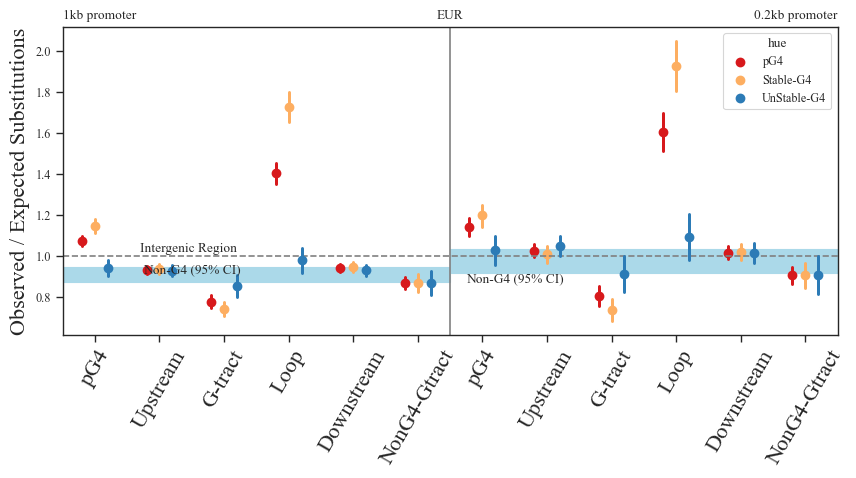

meta NOT subset; don't know how to subset; dropped


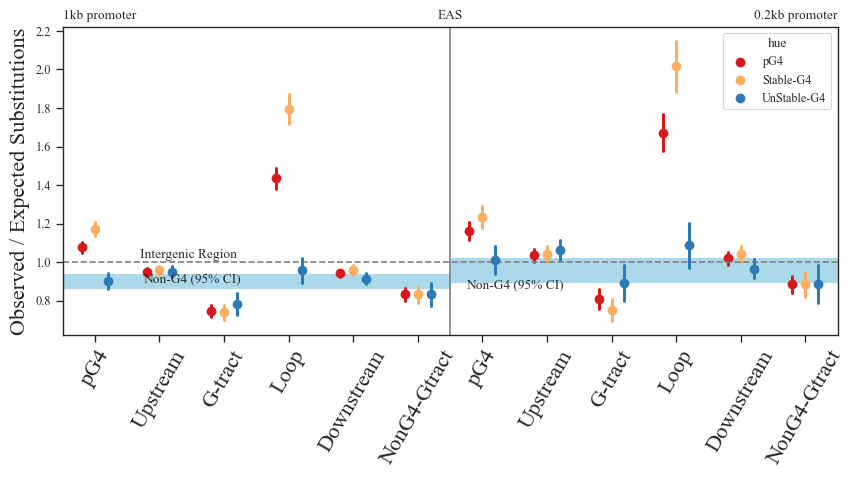

meta NOT subset; don't know how to subset; dropped


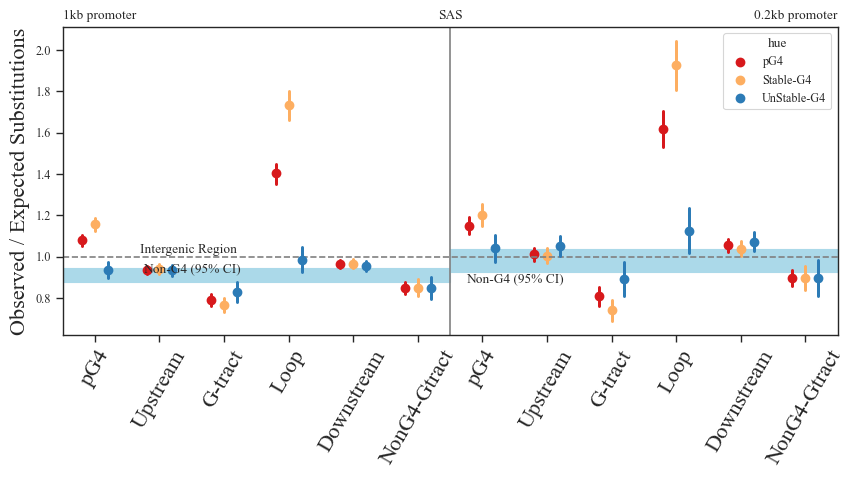

meta NOT subset; don't know how to subset; dropped


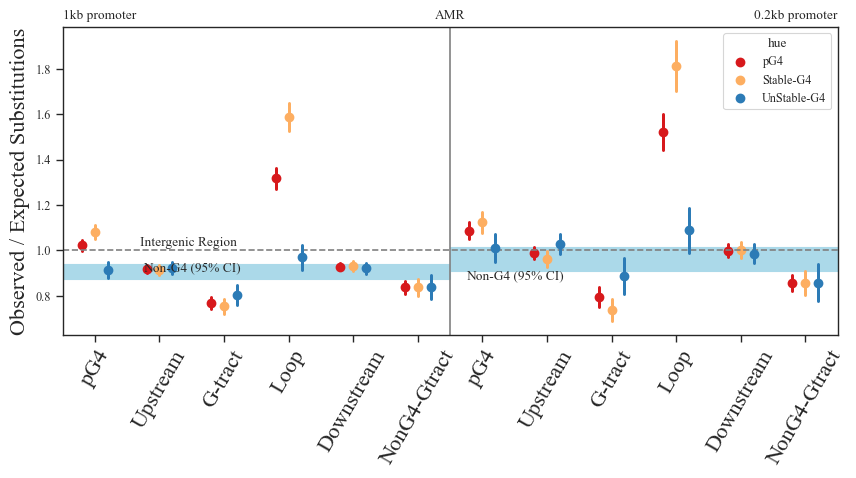

meta NOT subset; don't know how to subset; dropped


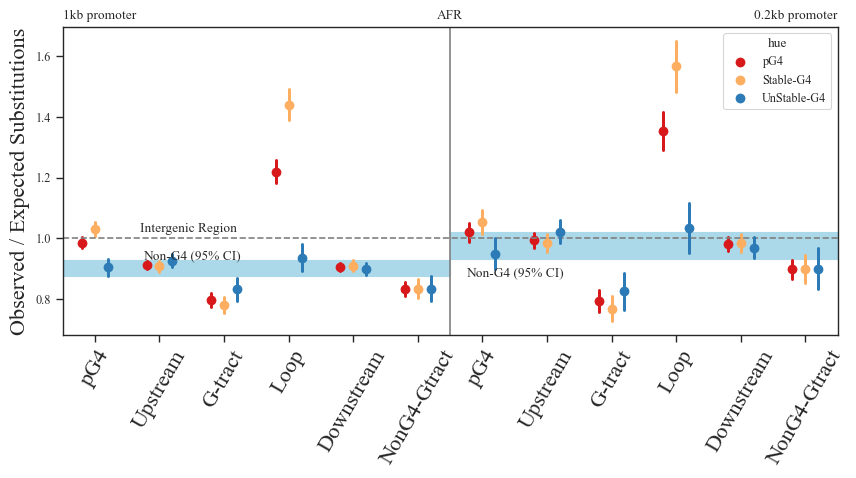

In [1]:
# -*- coding: utf-8 -*-
# @Time    : 2022/10/28 9:43
# @Author  : Guangyuel
# @File:   sevenver_drown_Figure.py

from scipy import stats
import pandas as pd
import sys, os
import numpy as np
import matplotlib as mpl
import seaborn as sns
import matplotlib.pyplot as plt


def data_annotion(df, key, groups="Promoter",hue="pG4"):
    df.loc[:, "g4_type"] = key
    df.loc[:, "groups"] = groups
    df.loc[:,"hue"] = hue
    return df

def data_merge(df,df_pG4, df_flank1,df_stem,df_loop,df_flank2,df_nonG4_Gtract, key):
    df_pG4 = df_pG4.loc[:, ["g4_type", key, "groups", "hue"]]
    tp_flank1 = df_flank1.loc[:, ["g4_type", key, "groups", "hue"]]
    tp_stem = df_stem.loc[:, ["g4_type", key, "groups", "hue"]]
    tp_loop = df_loop.loc[:, ["g4_type", key, "groups", "hue"]]
    tp_flank2 = df_flank2.loc[:, ["g4_type", key, "groups", "hue"]]
    tp_nonG4_gtract = df_nonG4_Gtract.loc[:, ["g4_type", key, "groups", "hue"]]
    return pd.concat([df,df_pG4,tp_flank1,tp_stem, tp_loop, tp_flank2, tp_nonG4_gtract])
    
def fig_plot(df, wd_path,key="EUR"):
    mpl.rcParams["pdf.fonttype"] = 42
    mpl.rcParams["ps.fonttype"] = 42
    plt.rcParams['font.sans-serif'] = ['Times New Roman']

    sns.set_context("paper")
    sns.set(style="ticks", context="paper",rc={'font.sans-serif':['Times New Roman']})
    fig, ax = plt.subplots(figsize=(10,4))
#     plt.figure()
    ax.axhspan(
        df[(df["groups"] == "Promoter") & (df["g4_type"] == "NonG4")][
            key].sort_values().values[249],
        df[(df["groups"] == "Promoter") & (df["g4_type"] == "NonG4")][
            key].sort_values().values[9750],
        xmin=0,
        xmax=0.5,
        color="#abd9e9")

    ax.axhspan(
        df[(df["groups"] == "Active promoter") & (df["g4_type"] == "NonG4")][
            key].sort_values().values[249],
        df[(df["groups"] == "Active promoter") & (df["g4_type"] == "NonG4")][
            key].sort_values().values[9750],
        xmin=0.5,
        xmax=1,
        color="#abd9e9")
    sns.pointplot(data=df[select_data[key]["g4_type"] != "NonG4"],
                  x="crossgroup", y=key, hue="hue",
                  join=False,
                  dodge=0.4,
                  n_boot=0,
                  errorbar=lambda y: (sorted(y)[int(len(y)*0.025)],
                                 sorted(y)[int(len(y)*0.975)]),
                  palette=['#d7191c','#fdae61','#2c7bb6'],
              ax=ax
             )    
    ax.axhline(y=1, color="grey", ls='--')
    ax.axvline(x=5.5, color="grey", ls='-')
    plt.text(x = 0.7 , y = 1.02, 
             s = "Intergenic Region", 
            ha = 'left')
    plt.text(x=1.5,
             y=df[(df["groups"] == "Active promoter") & (df["g4_type"] == "NonG4")][key].sort_values().values[255],
             s="Non-G4 (95% CI)",  
             ha='center')  
    plt.text(x=6.5,
             y=df[(df["groups"] == "Promoter") & (df["g4_type"] == "NonG4")][key].sort_values().values[255],
             s="Non-G4 (95% CI)",  
             ha='center')  
    plt.ylabel('Observed / Expected Substitutions', size=16)
    plt.xlabel('', size=16, )
    plt.xticks([0,1, 2, 3, 4, 5, 6, 7, 8,9,10,11], ["pG4","Upstream", "G-tract", "Loop", "Downstream","NonG4-Gtract"] * 2, size=16,
               rotation=60)
    plt.title(p)
    plt.title("1kb promoter",loc="left")
    plt.title("0.2kb promoter",loc="right")
    plt.savefig(os.path.join(wd_path,"sevenMer.ratio."+key+".pdf"))
    plt.show()


wd_path = "/disk2/G4_MS/frequency/Severmer"
population = ["EUR", "EAS", "SAS", "AMR", "AFR"]
ac_promoter_pG4 = data_annotion(pd.read_table(os.path.join(wd_path,"pG4","activePromoter_pG4.pG4.result.tsv")),
                               "pG4",
                               groups="Active promoter")
ac_promoter_stem = data_annotion(pd.read_table(os.path.join(wd_path, "activePromoter_pG4.stem.result.tsv")),
                              "G-tract",
                              groups="Active promoter")
ac_promoter_loop = data_annotion(pd.read_table(os.path.join(wd_path, "activePromoter_pG4.loop.result.tsv")),
                              "Loop",
                              groups="Active promoter")
ac_promoter_flank1 = data_annotion(pd.read_table(os.path.join(wd_path, "activePromoter_pG4.flank1.result.tsv")),
                                "Flank1",
                                groups="Active promoter")
ac_promoter_flank2 = data_annotion(pd.read_table(os.path.join(wd_path, "activePromoter_pG4.flank2.result.tsv")),
                                "Flank2",
                                groups="Active promoter")
ac_promoter_nonG4_Gtract = data_annotion(pd.read_table(os.path.join(wd_path, "activePromoter_nonpG4_boost.Gtract.result.tsv")),
                                         "nonG4-Gtract",
                                        groups = "Active promoter")

ac_promoter_nonG4 = data_annotion(pd.read_table(os.path.join(wd_path, "activePromoter_nonpG4_boost.result.tsv")),
                               "NonG4",
                               groups="Active promoter")
promoter_pG4 = data_annotion(pd.read_table(os.path.join(wd_path, "pG4","tss_sevenmer_pG4.results.tsv")), "pG4")
promoter_stem = data_annotion(pd.read_table(os.path.join(wd_path, "tss_pG4.stem.result.tsv")), "G-tract")
promoter_loop = data_annotion(pd.read_table(os.path.join(wd_path, "tss_pG4.loop.result.tsv")), "Loop")
promoter_flank1 = data_annotion(pd.read_table(os.path.join(wd_path, "tss_pG4.flank1.result.tsv")), "Flank1")
promoter_flank2 = data_annotion(pd.read_table(os.path.join(wd_path, "tss_pG4.flank2.result.tsv")), "Flank2")
promoter_nonG4_Gtract = data_annotion(pd.read_table(os.path.join(wd_path, "tss_nonpG4_boost.Gtract.result.tsv")), "nonG4-Gtract")
promoter_nonG4 = data_annotion(pd.read_table(os.path.join(wd_path, "tss_nonpG4_boost.result.tsv")), "NonG4")

### stable
ac_stable_promoter_pG4 = data_annotion(pd.read_table(os.path.join(wd_path,"pG4","activePromoter_pG4.Stable.result.tsv")),
                               "pG4",
                               groups="Active promoter",
                                hue="Stable-G4")
ac_stable_promoter_stem = data_annotion(pd.read_table(os.path.join(wd_path, "activePromoter_Stable_pG4.stem.result.tsv")),
                              "G-tract",
                              groups="Active promoter",hue="Stable-G4")
ac_stable_promoter_loop = data_annotion(pd.read_table(os.path.join(wd_path, "activePromoter_Stable_pG4.loop.result.tsv")),
                              "Loop",
                              groups="Active promoter",hue="Stable-G4")
ac_stable_promoter_flank1 = data_annotion(pd.read_table(os.path.join(wd_path, "activePromoter_Stable_pG4.flank1.result.tsv")),
                                "Flank1",
                                groups="Active promoter",hue="Stable-G4")
ac_stable_promoter_flank2 = data_annotion(pd.read_table(os.path.join(wd_path, "activePromoter_Stable_pG4.flank2.result.tsv")),
                                "Flank2",
                                groups="Active promoter",hue="Stable-G4")
ac_stable_promoter_nonG4_Gtract = data_annotion(pd.read_table(os.path.join(wd_path, "activePromoter_Stable_nonpG4_boost.Gtract.result.tsv")),
                                         "nonG4-Gtract",
                                        groups = "Active promoter",hue="Stable-G4")

promoter_stable_pG4 = data_annotion(pd.read_table(os.path.join(wd_path, "pG4","tss_sevenmer_pG4.Stable.results.tsv")), "pG4",hue="Stable-G4")
promoter_stable_stem = data_annotion(pd.read_table(os.path.join(wd_path, "tss_Stable_pG4.stem.result.tsv")), "G-tract", hue="Stable-G4")
promoter_stable_loop = data_annotion(pd.read_table(os.path.join(wd_path, "tss_Stable_pG4.loop.result.tsv")), "Loop", hue="Stable-G4")
promoter_stable_flank1 = data_annotion(pd.read_table(os.path.join(wd_path, "tss_Stable_pG4.flank1.result.tsv")), "Flank1", hue="Stable-G4")
promoter_stable_flank2 = data_annotion(pd.read_table(os.path.join(wd_path, "tss_Stable_pG4.flank2.result.tsv")), "Flank2", hue="Stable-G4")
promoter_stable_nonG4_Gtract = data_annotion(pd.read_table(os.path.join(wd_path, "tss_Stable_nonpG4_boost.Gtract.result.tsv")), "nonG4-Gtract", hue="Stable-G4")

## unstable 
ac_UnStable_promoter_pG4 = data_annotion(pd.read_table(os.path.join(wd_path,"pG4","activePromoter_pG4.unStable.result.tsv")),
                               "pG4",
                               groups="Active promoter",
                                hue="UnStable-G4")
ac_UnStable_promoter_stem = data_annotion(pd.read_table(os.path.join(wd_path, "activePromoter_UnStable_pG4.stem.result.tsv")),
                              "G-tract",
                              groups="Active promoter",hue="UnStable-G4")
ac_UnStable_promoter_loop = data_annotion(pd.read_table(os.path.join(wd_path, "activePromoter_UnStable_pG4.loop.result.tsv")),
                              "Loop",
                              groups="Active promoter",hue="UnStable-G4")
ac_UnStable_promoter_flank1 = data_annotion(pd.read_table(os.path.join(wd_path, "activePromoter_UnStable_pG4.flank1.result.tsv")),
                                "Flank1",
                                groups="Active promoter",hue="UnStable-G4")
ac_UnStable_promoter_flank2 = data_annotion(pd.read_table(os.path.join(wd_path, "activePromoter_UnStable_pG4.flank2.result.tsv")),
                                "Flank2",
                                groups="Active promoter",hue="UnStable-G4")
ac_UnStable_promoter_nonG4_Gtract = data_annotion(pd.read_table(os.path.join(wd_path, "activePromoter_UnStable_nonpG4_boost.Gtract.result.tsv")),
                                         "nonG4-Gtract",
                                        groups = "Active promoter",hue="UnStable-G4")

promoter_UnStable_pG4 = data_annotion(pd.read_table(os.path.join(wd_path, "pG4","tss_sevenmer_pG4.unStable.results.tsv")), "pG4",hue="UnStable-G4")
promoter_UnStable_stem = data_annotion(pd.read_table(os.path.join(wd_path, "tss_UnStable_pG4.stem.result.tsv")), "G-tract", hue="UnStable-G4")
promoter_UnStable_loop = data_annotion(pd.read_table(os.path.join(wd_path, "tss_UnStable_pG4.loop.result.tsv")), "Loop", hue="UnStable-G4")
promoter_UnStable_flank1 = data_annotion(pd.read_table(os.path.join(wd_path, "tss_UnStable_pG4.flank1.result.tsv")), "Flank1", hue="UnStable-G4")
promoter_UnStable_flank2 = data_annotion(pd.read_table(os.path.join(wd_path, "tss_UnStable_pG4.flank2.result.tsv")), "Flank2", hue="UnStable-G4")
promoter_UnStable_nonG4_Gtract = data_annotion(pd.read_table(os.path.join(wd_path, "tss_UnStable_nonpG4_boost.Gtract.result.tsv")), "nonG4-Gtract", hue="UnStable-G4")

select_data = {}


#     tp_nonG4 = ac_promoter_nonG4.loc[:, ["g4_type", p,"groups", "hue"]]
    
for p in population:
    tp_nonG4 = ac_promoter_nonG4.loc[:, ["g4_type", p,"groups", "hue"]]
    promoter_tp_nonG4 = promoter_nonG4.loc[:, ["g4_type", p,"groups", "hue"]]
    
    df = data_merge(promoter_tp_nonG4,
                    promoter_pG4,
                    promoter_flank1,
                    promoter_stem,
                    promoter_loop,
                    promoter_flank2,
                    promoter_nonG4_Gtract,
                    p
                   )
    df = pd.concat([tp_nonG4, df])
    df = data_merge(df,
                    ac_promoter_pG4,
                    ac_promoter_flank1,
                    ac_promoter_stem,
                    ac_promoter_loop, 
                    ac_promoter_flank2, 
                    ac_promoter_nonG4_Gtract,
                    p)
    
    ## Stable 
    df = data_merge(df,
                    promoter_stable_pG4,
                    promoter_stable_flank1,
                    promoter_stable_stem,
                    promoter_stable_loop,
                    promoter_stable_flank2,
                    promoter_stable_nonG4_Gtract,
                    p
                   )
    df = data_merge(df,
                    ac_stable_promoter_pG4,
                    ac_stable_promoter_flank1,
                    ac_stable_promoter_stem,
                    ac_stable_promoter_loop, 
                    ac_stable_promoter_flank2, 
                    ac_stable_promoter_nonG4_Gtract,p)

    # Unstable

    df = data_merge(df,
                    promoter_UnStable_pG4,
                    promoter_UnStable_flank1,
                    promoter_UnStable_stem,
                    promoter_UnStable_loop,
                    promoter_UnStable_flank2,
                    promoter_UnStable_nonG4_Gtract,
                    p
                   )
    df = data_merge(df,
                    ac_UnStable_promoter_pG4,
                    ac_UnStable_promoter_flank1,
                    ac_UnStable_promoter_stem,
                    ac_UnStable_promoter_loop, 
                    ac_UnStable_promoter_flank2, 
                    ac_UnStable_promoter_nonG4_Gtract,
                   p
                   )
  
    df.loc[:,"crossgroup"] = df["g4_type"]+"|"+ df["groups"]
    select_data[p] = df
    fig_plot(df,os.path.join(wd_path,"pG4"),key=p)
